# Parameter Identifiability

In [1]:
import pandas
# from Myelotoxicity_pkpd.PK_model import PintsLinCompIV
from Myelotoxicity_pkpd.Likelihoods import MultiplicativeGaussianLogLikelihood, GaussianLogLikelihood, ConstantAndMultiplicativeGaussianLogLikelihood
from Myelotoxicity_pkpd.PD_model import PintsPDFriberg
import pints
# import pints.plot
# import pints.io
import numpy as np
import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.graph_objects as go
# import plotly.figure_factory as ff

In [2]:
drug = 'Docetaxel'
dose = 10.0
num_comp = 2
observation_name = 'Platelets '

## Simulated Data

In [3]:
PD_actual_params = np.load("Data_and_parameters/pd_sim_actual_params_dose_2.npy")
PD_param_names = ["Circ_0", "MTT", "gamma", "slope", "sigma_base", "eta", "sigma_rel"]
print("Parameters used for simulated data:")
for i in range(0,len(PD_param_names)):
    print(PD_param_names[i] + " = " + str(PD_actual_params[i]))

Parameters used for simulated data:
Circ_0 = 983.1
MTT = 85.26
gamma = 0.44
slope = 0.02
sigma_base = 42.43
eta = 1.0
sigma_rel = 0.13


In [4]:
PK_params=np.load('simulated_parameters_actual_dose2.npy')
df = pandas.read_csv("./Data_and_parameters/pd_sim_data_dose_2")
start_time = df['TIME'].min()
PD_model = PintsPDFriberg(PK_params, 2, start_time=start_time)
print(df)

df_before_0 = df[df["TIME"] < 0]
times_before_dose = len(df_before_0["OBS"])
Circ_0_approx = sum(df_before_0["OBS"])/times_before_dose
print("approximate Circ_0: ", Circ_0_approx)

     TIME          OBS
0   -48.0   869.130612
1    24.0   961.271692
2    48.0   790.014183
3    72.0   769.877641
4    96.0   736.797276
5   120.0   561.013744
6   144.0   603.514381
7   168.0   584.144579
8   192.0   787.642479
9   216.0  1029.831275
10  240.0  1164.806321
11  264.0  1469.608502
12  288.0  1367.173049
13  312.0  1212.623130
14  336.0  1540.622999
15  360.0  1013.834055
16  384.0  1116.095449
17  432.0   901.822080
18  480.0   728.172928
19  552.0  1031.239362
approximate Circ_0:  869.1306122827878


In [5]:
opt_df = pandas.read_csv("./Data_and_parameters/PD_sim/opt_results.csv")
opt_point_comb = opt_df.loc[3,:].values[2:9]

lower_bound = [0.01*Circ_0_approx, df['TIME'].max()*0.01, 0.001, 0.001, 0.005, 0.001, 0.0001]
upper_bound = [100*Circ_0_approx, df['TIME'].max()*0.5, 5, 100, 1000, 10, 1]
print('Initial point for profile likelihood')
for i in range(0,len(PD_param_names)):
    print(PD_param_names[i] + " = " + str(opt_point_comb[i]))

Initial point for profile likelihood
Circ_0 = 974.928581528346
MTT = 83.68306101500464
gamma = 0.4164428569194671
slope = 0.0192596079549873
sigma_base = 12.489882766574263
eta = 1.6381622423422335
sigma_rel = 0.0010000000001915


In [16]:
def single_profile_loglikelihood(param_index, param_values, point_start, fix_noise = [None]*3):
    likelihood = []
    point = point_start
    for i, x in enumerate(param_values):
        print("\r", str((i/len(param_values)+n)*50)+"% complete", sep=' ', end='', flush=True)
        fix_i_noise = fix_noise
        
        if param_index < 4:
            fix_param=[[param_index], [x]]
        else:
            fix_param=[[], []]
            fix_i_noise[param_index-4] = x
        
        pints_model_simulated = PintsPDFriberg(
            PK_params, 
            dose, 
            fix_param=fix_param, 
            start_time=start_time
        )
        problem = pints.SingleOutputProblem(
            pints_model_simulated, 
            df['TIME'].to_numpy()-start_time, 
            df['OBS'].to_numpy()
        )
        log_likelihood = ConstantAndMultiplicativeGaussianLogLikelihood(problem, fix_noise=fix_i_noise)
        error_measure = pints.ProbabilityBasedError(log_likelihood)
        unchanged_threshold = 1e-4
        
        optimisation = pints.OptimisationController(error_measure, point, method=pints.NelderMead)
        optimisation.set_max_unchanged_iterations(threshold=unchanged_threshold)

        optimisation.set_log_to_screen(False)
        point, error = optimisation.run()
        likelihood.append([x, -error])
    return(likelihood)

In [12]:
fix_eta = [None, 1, None]

for param_index in [4,6]:
    print("\n Profile likelihood for " + PD_param_names[param_index]+ ":")
    if param_index<5:
        point = np.concatenate((opt_point_comb[:param_index], opt_point_comb[param_index+1:5], opt_point_comb[6:]))
    elif param_index>5:
        point = np.concatenate((opt_point_comb[:5], opt_point_comb[6:param_index], opt_point_comb[param_index+1:]))
    if param_index!=5:
        n=0
        param_range = np.linspace(1*opt_point_comb[param_index], 0.5*opt_point_comb[param_index], 100)
        likelihood_lower = single_profile_loglikelihood(param_index, param_range, point, fix_noise=fix_eta)

        n+=1
        param_range = np.linspace(1*opt_point_comb[param_index], 1.5*opt_point_comb[param_index], 100)
        likelihood_upper = single_profile_loglikelihood(param_index, param_range, point, fix_noise=fix_eta)

        likelihood_lower.reverse()
        likelihood = np.array(likelihood_lower+likelihood_upper)
        np.save("./Data_and_parameters/PD_sim/identify_comb_noeta_param_"+str(param_index), likelihood)


 Profile likelihood for sigma_rel:
 99.5% complete001% completee

In [6]:
def pair_profile_likelihood(param_index_1, param_index_2, param_values_1, param_values_2, point_start, fix_noise = [None]*3):
    point_next_line = point_start
    likelihood_matrix = np.zeros((len(param_values_1), len(param_values_2)))
    
    for i, x_1 in enumerate(param_values_1):
        print("\r", str(np.round((i/len(param_values_1)+n)*25, decimals=4))+"% complete", sep=' ', end='', flush=True)
        point = point_next_line
        
        for j, x_2 in enumerate(param_values_2):
            fix_mech = [[],[]]
            fix_ij_noise = fix_noise
            if param_index_1<4:
                fix_mech[0].append(param_index_1)
                fix_mech[1].append(x_1)
            else: 
                fix_ij_noise[param_index_1-4]=x_1
            if param_index_2<4:
                fix_mech[0].append(param_index_2)
                fix_mech[1].append(x_2)
            else: 
                fix_ij_noise[param_index_2-4]=x_2
            pints_model = PintsPDFriberg(
                PK_params, dose,
                fix_param=fix_mech,
                start_time=start_time
            )
            problem = pints.SingleOutputProblem(
                pints_model, 
                df['TIME'].to_numpy()-start_time, 
                df['OBS'].to_numpy()
            )
            
            log_likelihood = ConstantAndMultiplicativeGaussianLogLikelihood(problem, fix_noise=fix_ij_noise)  
            error_measure = pints.ProbabilityBasedError(log_likelihood)

            unchanged_threshold = 1e-4

            optimisation = pints.OptimisationController(error_measure, point, method=pints.NelderMead)
            optimisation.set_max_unchanged_iterations(threshold=unchanged_threshold)
            
            optimisation.set_log_to_screen(False)
            point, error = optimisation.run()
            likelihood_matrix[i,j] = -error

            if j==0:
                point_next_line = point
    return likelihood_matrix

In [7]:
# For double parameters
for param_index_1 in [6]:
    param_range_1_lower = np.linspace(1*opt_point_comb[param_index_1], 0.5*opt_point_comb[param_index_1], 10)
    param_range_1_upper = np.linspace(1*opt_point_comb[param_index_1], 1.5*opt_point_comb[param_index_1], 10)
    for param_index_2 in [4]:
        print("\n Pairwise Profile likelihood for " + PD_param_names[param_index_1] + " and " + PD_param_names[param_index_2] + ":")

        param_range_2_left = np.linspace(1*opt_point_comb[param_index_2], 0.5*opt_point_comb[param_index_2], 10)
        param_range_2_right = np.linspace(1*opt_point_comb[param_index_2], 1.5*opt_point_comb[param_index_2], 10)
        
        if param_index_1<5:
            pass
        
        elif (param_index_2<5 and param_index_1>5):
            point_start = np.concatenate((
                opt_point_comb[:param_index_2],
                opt_point_comb[param_index_2+1:5],
                opt_point_comb[6:param_index_1], 
                opt_point_comb[param_index_1+1:]
            ))
        elif param_index_2>5:
            pass
        fix_eta = [None, 1, None]

        
        n=0
        likelihood_lower_left = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_lower, 
            param_range_2_left, 
            point_start,
            fix_noise = fix_eta
        )
        likelihood_lower_left = np.fliplr(likelihood_lower_left[:,1:])
        
        n=1
        likelihood_upper_left = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_upper, 
            param_range_2_left, 
            point_start,
            fix_noise = fix_eta
        )
        likelihood_upper_left = np.fliplr(np.flipud(likelihood_upper_left[1:,1:]))
        
        n=2
        likelihood_lower_right = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_lower, 
            param_range_2_right, 
            point_start,
            fix_noise = fix_eta
        )
        
        n=3
        likelihood_upper_right = pair_profile_likelihood(
            param_index_1,
            param_index_2, 
            param_range_1_upper, 
            param_range_2_right, 
            point_start,
            fix_noise = fix_eta
        )
        likelihood_upper_right = np.flipud(likelihood_upper_right[1:,:])
        
        likelihood_upper = np.concatenate((likelihood_upper_left, likelihood_upper_right), axis=1)
        likelihood_lower = np.concatenate((likelihood_lower_left, likelihood_lower_right), axis=1)
        likelihood =  np.concatenate((likelihood_upper, likelihood_lower), axis=0)
        
        np.save("./Data_and_parameters/PD_sim/identify_comb_noeta_param_"+str(param_index_1)+"_"+str(param_index_2)+"_dose_"+str(dose), likelihood)


 Pairwise Profile likelihood for sigma_rel and sigma_base:
[974.928581528346 83.68306101500464 0.4164428569194671 0.0192596079549873]
 97.5% complete

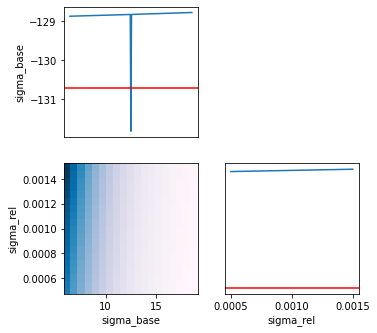

In [14]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(18.5*2.0/7.0, 18.5*2.0/7.0)
dose = 10.0
param_indices = [4,6]
for y_axes in range(0,2):
    i = param_indices[y_axes]
    for x_axes in range(0,2):
        j = param_indices[x_axes]
        if i == j:
            likelihood = np.load("./Data_and_parameters/PD_sim/identify_comb_noeta_param_"+str(i)+".npy")

            ax[y_axes, x_axes].plot(likelihood[:,0], likelihood[:,1])
            ax[y_axes, x_axes].axhline(y=np.max(likelihood[:,1])-(3.84/2), linestyle='-', color='r')
            if (PD_actual_params[i]<np.max(likelihood[:,0]) and PD_actual_params[i]>np.min(likelihood[:,0])):
                ax[y_axes, x_axes].axvline(x=PD_actual_params[i], linestyle='--', color='r')
        elif j<i:
            likelihood = np.load("./Data_and_parameters/PD_sim/identify_comb_noeta_param_"+str(i)+"_"+str(j)+"_dose_"+str(dose)+".npy")
            y_range = np.linspace(0.5*opt_point_comb[i], 1.5*opt_point_comb[i], 19)
            x_range = np.linspace(0.5*opt_point_comb[j], 1.5*opt_point_comb[j], 19)

            colouring = ax[y_axes, x_axes].pcolormesh(x_range, y_range, likelihood, vmin=likelihood.min(), vmax=likelihood.max(), cmap='PuBu_r', shading='auto')
            
#             ax[i, j].axvline(x=PD_actual_params[j], linestyle='--', color='r')
#             ax[i, j].axhline(y=PD_actual_params[i], linestyle='--', color='r')
        
        else:
            ax[y_axes, x_axes].set_axis_off()
        
#         fig.colorbar(colouring, ax=ax[i,j], extend='max')
        if y_axes == 1:
            ax[y_axes, x_axes].set_xlabel(PD_param_names[j])
        else:
            ax[y_axes, x_axes].set_xticks([])
        if x_axes == 0:
            ax[y_axes, x_axes].set_ylabel(PD_param_names[i])
        else:
            ax[y_axes, x_axes].set_yticks([])

In [27]:
opt_point_add = opt_df.loc[0,:].values[2:7]
print(opt_point_add)
opt_point_mult = np.concatenate((opt_df.loc[2,:].values[2:6], opt_df.loc[2,:].values[8:9]))
print(opt_point_mult)


for param_index in [4,6]:
    print("\n Profile likelihood for " + PD_param_names[param_index]+ ":")
    if param_index<5:
        fix_eta = [None, 1, 0]
        point = opt_point_add[:param_index]
        file_name = "./Data_and_parameters/PD_sim/identify_add_param_"+str(param_index)
        opt = opt_point_add
    elif param_index>5:
        fix_eta = [0, 1, None]
        point = np.concatenate((opt_point_mult[:4], opt_point_mult[6:param_index], opt_point_mult[param_index+1:]))
        file_name = "./Data_and_parameters/PD_sim/identify_mult_noeta_param_"+str(param_index)
        opt = opt_point_mult
    if param_index!=5:
        n=0
        param_range = np.linspace(1*opt[param_index], 0.5*opt[param_index], 10)
        likelihood_lower = single_profile_loglikelihood(param_index, param_range, point, fix_noise=fix_eta)

        n+=1
        param_range = np.linspace(1*opt[param_index], 1.5*opt[param_index], 10)
        likelihood_upper = single_profile_loglikelihood(param_index, param_range, point, fix_noise=fix_eta)

        likelihood_lower.reverse()
        likelihood = np.array(likelihood_lower+likelihood_upper)
        np.save(file_name, likelihood)

[869.1478866517645 21.882905813281926 13.856141496339148
 20.739125468442257 99.8872882575176]
[975.0746810883232 83.26690590579929 0.4130737919944303 0.0192957738303407
 0.0942497395080935]

 Profile likelihood for sigma_base:
 95.0% complete001% complete
 Profile likelihood for sigma_rel:


IndexError: index 6 is out of bounds for axis 0 with size 5

In [ ]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18.5*2.0/7.0, 18.5/7.0)
dose = 10.0
param_indices = [4,6]
for y_axes in range(0,1):
    for x_axes in range(0,2):
        i = param_indices[x_axes]
        
        if i == 4:
            likelihood = np.load("./Data_and_parameters/PD_sim/identify_add_param_"+str(i)+".npy")
        if i==6:
            likelihood = np.load("./Data_and_parameters/PD_sim/identify_mult_noeta_param_"+str(i)+".npy")
            

        ax[x_axes].plot(likelihood[:,0], likelihood[:,1])
        ax[x_axes].axhline(y=np.max(likelihood[:,1])-(3.84/2), linestyle='-', color='r')
        if (PD_actual_params[i]<np.max(likelihood[:,0]) and PD_actual_params[i]>np.min(likelihood[:,0])):
            ax[x_axes].axvline(x=PD_actual_params[i], linestyle='--', color='r')
        
#         fig.colorbar(colouring, ax=ax[i,j], extend='max')
        ax[x_axes].set_xlabel(PD_param_names[i])
        ax[x_axes].set_yticks([])